In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from qmmc import *

## Format data

In [3]:
df = pd.read_csv('/Users/rachez/ETSAnonymousPricesFull.csv')

/Users/rachez/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (9,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
idx_buy = df["BuySell"].values == "Buy"
df = df[idx_buy]

idx_done = df["TradeStatus"].values == "Done"
idx_traded_away = df["TradeStatus"].values == "TradedAway"
idx_not_traded = df["TradeStatus"].values == "NotTraded"
df = df[idx_done + idx_traded_away + idx_not_traded]

df["Y"] = (df["BNPPAnsweredQuote"] - df["RFQCompositePrice"]) / np.abs(df["Bid2Mid"])
df = df[df["Y"] < 2]
df = df[df["Y"] > -2]

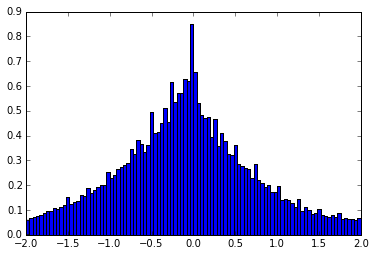

In [5]:
plt.hist(df["Y"].values, bins=100, normed=True)
plt.show()

In [6]:
n = 3
dd = df[df["NbDealers"] == n + 1]

Y_real = dd["Y"].values

I = dd["TradeStatus"].values
II = np.empty(I.shape[0], dtype=int)
II[I == "Done"] = 2
II[I == "TradedAway"] = 1
II[I == "NotTraded"] = 0
I_real = II

In [7]:
m = 5000
n_samples = Y_real.shape[0]
idx = np.random.randint(0, n_samples, m)

In [8]:
Y_real = Y_real[idx]
I_real = I_real[idx]

In [9]:
Y_real.shape

(5000,)

## Estimate model parameters from data

Using the same graphical model - with different initial values for latent variables and parameters- we now use a custom Gibbs sampler to recover the parameters.

In [10]:
# Priors
mu_0, sigma_0 = Value(0), Value(10)
scale_0, shape_0 = Value(3), Value(3)
a_0, b_0 = Value(1), Value(1)

# Parameters
loc_V = Normal(mu_0, sigma_0, value=0, name='loc_V')
scale_V = InvGamma(scale_0, shape_0, value=3, name='scale_V')

loc_W = Normal(mu_0, sigma_0, value=0, name='loc_W')
scale_W = InvGamma(scale_0, shape_0, value=3, name='scale_W')

p = Beta(a_0, b_0, value=0.5, name='p')

# Variables
k = np.empty(m, dtype=object)
V = np.empty(m, dtype=object)
W = np.empty(m, dtype=object)
Y = np.empty(m, dtype=object)
I = np.empty(m, dtype=object)
for i in xrange(m):
    k[i] = Binomial(p, Value(n), name='k_%d' % i)
    V[i] = Laplace(loc_V, scale_V, name='V_%d' % i)
    W[i] = BernoulliLaplace(loc_W, scale_W, k[i], name='W_%d' % i)
    Y[i] = Value(Y_real[i])
    
    @Function
    def S_i(Y=Y[i], V=V[i], W=W[i]):
        
        if len(W) > 0:
            C = np.min(W)
        else:
            C = np.inf
        
        if Y <= np.minimum(C, V): return 2
        if C <= np.minimum(Y, V): return 1
        if V < np.minimum(C, Y): return 0
    
    I[i] = BernoulliFlip(Value(0.0), S_i, k=3, value=I_real[i], observed=True, name='I_%d' % i)

In [11]:
all_variables = [loc_V, loc_W, scale_V, scale_W]
all_variables.extend(V)
all_variables.extend(W)
all_variables.extend(k)
all_variables.extend([p])

In [12]:
kvw_samplers = np.empty(m, dtype=object)
for i in xrange(m):
    kvw_sampler = KVWSampler(k[i], V[i], W[i], Y[i], I[i])
    kvw_samplers[i] = kvw_sampler
p_sampler = NormalMHSampler(p, scaling=0.01)
all_samplers = list(kvw_samplers)
all_samplers.append(p_sampler)

In [13]:
model = Model(variables=all_variables, samplers=all_samplers)

In [ ]:
%%time
model.estimate(5000)

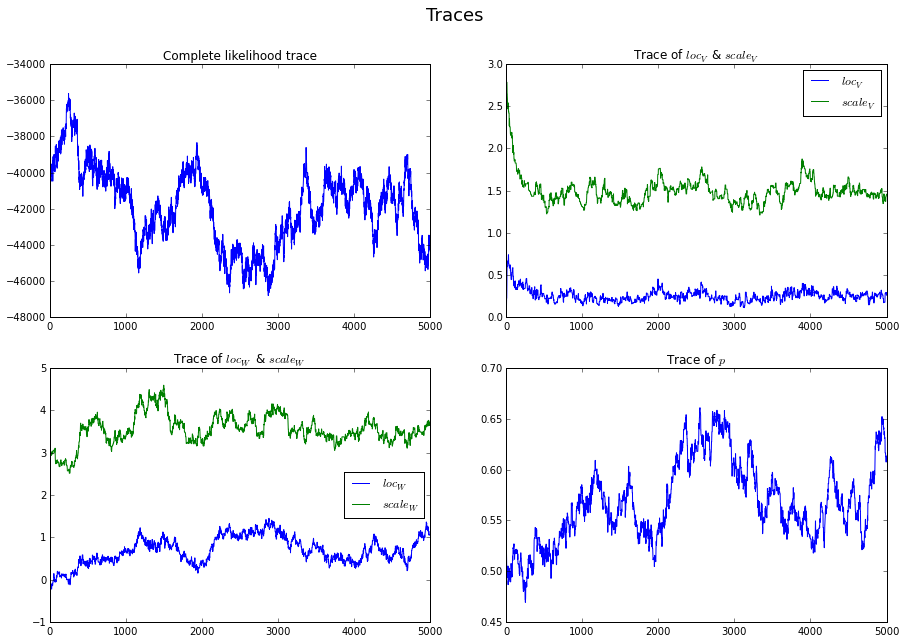

In [15]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(model.logp_hist)
plt.title("Complete likelihood trace")

plt.subplot(2, 2, 2)
loc_V_trace = model.samplers['loc_V'].get_history()
scale_V_trace = model.samplers['scale_V'].get_history()
plt.plot(loc_V_trace)
plt.plot(scale_V_trace)
plt.legend([r"$loc_V$", r"$scale_V$"], loc='best')
plt.title(r"Trace of $loc_V$ & $scale_V$")

plt.subplot(2, 2, 3)
loc_W_trace = model.samplers['loc_W'].get_history()
scale_W_trace = model.samplers['scale_W'].get_history()
plt.plot(loc_W_trace)
plt.plot(scale_W_trace)
plt.legend([r"$loc_W$", r"$scale_W$"], loc='best')
plt.title(r"Trace of $loc_W$ & $scale_W$")

plt.subplot(2, 2, 4)
p_trace = model.samplers['p'].get_history()
plt.plot(p_trace)
plt.title(r"Trace of $p$")

plt.suptitle(r"Traces", size=18)
plt.show()

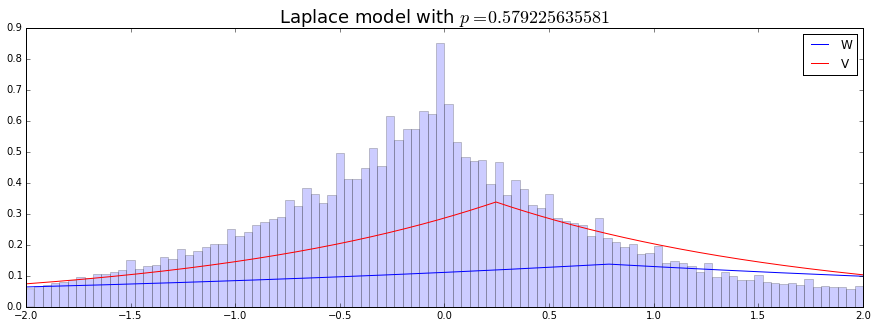

In [16]:
from scipy.stats import laplace

plt.figure(figsize=(15, 5))

n_burn = 1000
loc_V_avg = np.mean(loc_V_trace[n_burn:])
scale_V_avg = np.mean(scale_V_trace[n_burn:])
loc_W_avg = np.mean(loc_W_trace[n_burn:])
scale_W_avg = np.mean(scale_W_trace[n_burn:])
p_avg = np.mean(p_trace[n_burn:])

xx = np.linspace(-2, 2, 1000)

plt.plot(xx, laplace.pdf(xx, loc_W_avg, scale_W_avg), color='b')
plt.plot(xx, laplace.pdf(xx, loc_V_avg, scale_V_avg), color='r')
plt.hist(df["Y"].values, bins=100, normed=True, alpha=0.2)

plt.legend(['W', 'V'])
plt.title(r"Laplace model with $p = %s$" % p_avg, size=18)
plt.show() 